# Previsão de fatalidade em um acidente
Classificação
Gravidade Fatal

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import impute 
from sklearn import preprocessing
from sklearn import compose
from sklearn import metrics
from sklearn import ensemble
from sklearn import pipeline
from sklearn import dummy
from sklearn import tree
import mlflow
import xgboost

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')

In [2]:
## fontes dos dados: https://dadosabertos.sp.gov.br/dataset/sinistros-infosiga
raw = pd.read_csv('data/sinistros_2022-2025.csv', encoding='latin-1', on_bad_lines='skip', sep=';', decimal=',')
sinistro = raw.copy()

In [ ]:
sinistro.shape

In [ ]:
sinistro.dtypes

In [ ]:
sinistro.head(5)
## colunas de gravidade indicam quantidade de pessoas em tal situação

In [ ]:
sinistro.info()

# Cleaning

In [3]:
## removendo linhas duplicadas e colunas não desejadas
list(sinistro.columns)
to_remove = ['id_sinistro', 'tipo_acidente_primario',
             'ano_mes_sinistro', 'ano_sinistro',
             'logradouro', 'numero_logradouro',
             'municipio', 'regiao_administrativa',
             'administracao', 'conservacao',
             'jurisdicao', 'latitude',
             'longitude', 'tipo_registro']
sinistro.drop(columns=to_remove, inplace=True)
sinistro.drop_duplicates(inplace=True)

In [ ]:
sinistro.columns

In [ ]:
## verificando nulls
sinistro.isnull().sum()

In [4]:
## data types
## hora_sinistro (object -> int)
## tp_sinistro_ está preenchido com 'S' -> trocar para 1
sinistro.dtypes
sinistro['hora_sinistro'] = pd.to_numeric(sinistro['hora_sinistro'].str[:2], errors='coerce')

In [5]:
## % de valores nulos em 'hora_sinistro'
(sinistro['hora_sinistro'].isnull().sum()/len(sinistro)) * 100

np.float64(0.11430645014968702)

In [5]:
## tp_sinistro_ 'S' -> 1
tipos = [col for col in sinistro.columns if col.startswith('tp_sinistro_')]
for col in tipos:
    sinistro[col] = sinistro[col].replace('S','1')
    sinistro[col] = pd.to_numeric(sinistro[col], errors='coerce')

In [6]:
## criar coluna 'periodo_dia'
def criar_periodos(hora):
    if 6 <= hora < 12:
        return 'manha'
    elif 12 <= hora < 18:
        return 'tarde'
    elif 18 <= hora < 24:
        return 'noite'
    elif hora < 6:
        return 'madrugada'
    else:
        return 'nao_disponivel'

sinistro['periodo_dia'] = sinistro['hora_sinistro'].apply(criar_periodos)
sinistro.drop(columns='hora_sinistro',inplace=True)

In [7]:
## criar coluna 'dia_semana'
## 'data_sinistro' = object
## object -> datatime
sinistro['data_sinistro'] = pd.to_datetime(sinistro['data_sinistro'], format='%d/%m/%Y')
sinistro['dia_semana'] = sinistro['data_sinistro'].dt.day_name()
sinistro.drop(columns='data_sinistro',inplace=True)

In [8]:
## preenchendo NaN com 0 nas colunas binárias
veiculos = [col for col in sinistro.columns if col.startswith('tp_veiculo_')]
gravidade = [col for col in sinistro.columns if col.startswith('gravidade_')]

sinistro[veiculos] = sinistro[veiculos].fillna(0)
sinistro[gravidade] = sinistro[gravidade].fillna(0)
sinistro[tipos] = sinistro[tipos].fillna(0)


In [9]:
## criando coluna 'qtd_pessoas' e 'qtd_veiculos'
sinistro['qtd_pessoas'] = sinistro[gravidade].sum(axis=1).astype(int)
sinistro['qtd_veiculos'] = sinistro[veiculos].sum(axis=1).astype(int)
sinistro['qtd_tipos_sinistro'] = (sinistro[[c for c in sinistro.columns if c.startswith('tp_sinistro_')]].sum(axis=1)).astype(int)


In [10]:
## transformando 'gravidade_fatal' em binário
sinistro['gravidade_fatal'] = (sinistro['gravidade_fatal']>0).astype(int)
sinistro['gravidade_grave'] = (sinistro['gravidade_grave']>0).astype(int)

In [11]:
## juntando coluna 'gravidade_fatal' com 'gravidade_grave'
sinistro['acidente_grave'] = ((sinistro['gravidade_fatal'] > 0) | (sinistro['gravidade_grave'] > 0)).astype(int)
sinistro.drop(columns=gravidade, inplace=True)

In [ ]:
sinistro.head()

In [12]:
sinistro.reset_index(inplace=True, drop=True)

In [13]:
## criando colunas novas
sinistro['veiculo_pesado'] = ((sinistro['tp_veiculo_caminhao']>0) | (sinistro['tp_veiculo_onibus']>0)).astype(int)
sinistro['pessoas_por_veiculos'] = (sinistro['qtd_pessoas']/sinistro['qtd_veiculos'])
sinistro['fim_de_semana'] = ((sinistro['dia_semana'] == 'Friday') | 
                             (sinistro['dia_semana'] == 'Saturday') | 
                             (sinistro['dia_semana'] == 'Sunday')).astype(int)
sinistro['alta_velocidade_provavel'] = (sinistro['tipo_via'] == 'RODOVIAS').astype(int)
sinistro['claridade_escuro'] = ((sinistro['periodo_dia'] == 'madrugada') | (sinistro['periodo_dia'] == 'noite')).astype(int)
sinistro['provavel_velocidade_noturna'] = ((sinistro['claridade_escuro']>0) & (sinistro['alta_velocidade_provavel']>0)).astype(int)

In [14]:
## tratando pessoas por veiculos
sinistro['pessoas_por_veiculos'] = sinistro['pessoas_por_veiculos'].replace([np.inf,-np.inf],np.nan)
sinistro['pessoas_por_veiculos'] = sinistro['pessoas_por_veiculos'].fillna(sinistro['qtd_pessoas'])
sinistro['pessoas_por_veiculos'] = sinistro['pessoas_por_veiculos'].fillna(0)

In [15]:
cat_cols = sinistro.select_dtypes('object').columns.to_list()
num_cols = sinistro.select_dtypes(include=['int64','float64']).columns.to_list()

# Split

In [ ]:
target = 'acidente_grave'
X = sinistro.drop(columns=[target])
y = sinistro[target]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.2, 
                                                                    random_state=42,
                                                                    stratify=y)

# Análise

In [20]:
X_train.head()

,mes_sinistro,dia_sinistro,tipo_via,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel,tp_sinistro_atropelamento,tp_sinistro_colisao_frontal,tp_sinistro_colisao_traseira,tp_sinistro_colisao_lateral,tp_sinistro_colisao_transversal,tp_sinistro_colisao_outros,tp_sinistro_choque,tp_sinistro_capotamento,tp_sinistro_engavetamento,tp_sinistro_tombamento,tp_sinistro_outros,tp_sinistro_nao_disponivel,periodo_dia,dia_semana,qtd_pessoas,qtd_veiculos,qtd_tipos_sinistro,veiculo_pesado,pessoas_por_veiculos,fim_de_semana,alta_velocidade_provavel,claridade_escuro,provavel_velocidade_noturna
516510,8,15,VIAS MUNICIPAIS,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tarde,Thursday,3,4,2,0,0.75,0,0,0,0
642602,4,26,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tarde,Saturday,1,1,1,0,1.00,1,0,0,0
156932,10,30,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tarde,Sunday,0,0,1,0,0.00,1,0,0,0
481155,6,11,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,noite,Tuesday,0,0,1,0,0.00,0,0,1,0
102885,7,22,VIAS MUNICIPAIS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,tarde,Friday,1,1,1,0,1.00,1,0,0,0


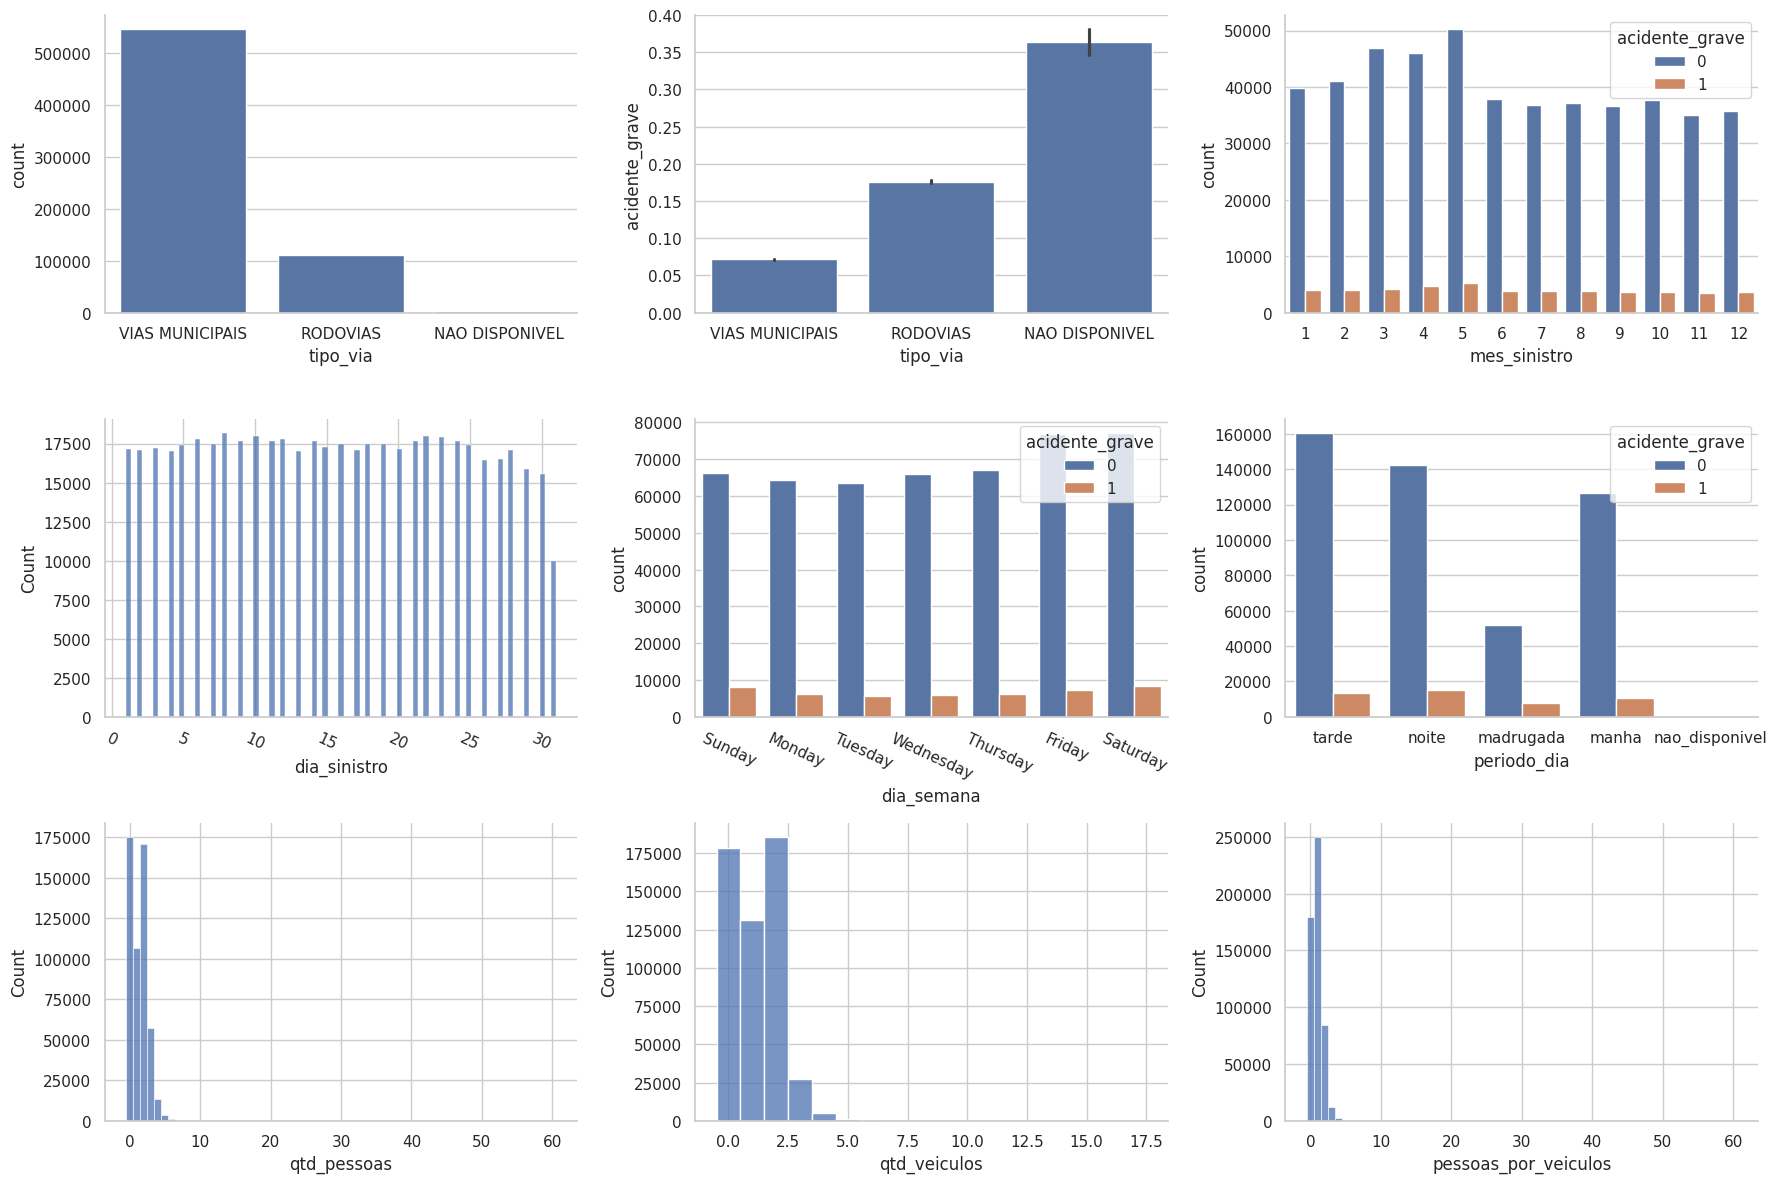

In [84]:
##
fig, ax = plt.subplots(3,3, figsize=(18,12))

sns.countplot(ax = ax[0,0], data=sinistro, x='tipo_via')

sns.barplot(ax = ax[0,1], data=sinistro, x='tipo_via', y='acidente_grave')

sns.countplot(ax = ax[0,2], data=X_train, x='mes_sinistro', hue=y_train)

sns.histplot(ax = ax[1,0], data=X_train, x='dia_sinistro')

sns.countplot(ax = ax[1,1], data=X_train, x='dia_semana', hue=y_train, order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
ax[1,0].tick_params(axis='x',rotation=-25)

sns.countplot(ax = ax[1,2], data=X_train, x='periodo_dia', hue=y_train)
ax[1,1].tick_params(axis='x',rotation=-25)

sns.histplot(ax = ax[2,0], data=X_train, x='qtd_pessoas',discrete=True)

sns.histplot(ax=ax[2,1], data=X_train, x='qtd_veiculos',discrete=True)

sns.histplot(ax = ax[2,2], data=X_train, x='pessoas_por_veiculos',discrete=True)

sns.despine(fig=fig)
plt.tight_layout()
plt.show()

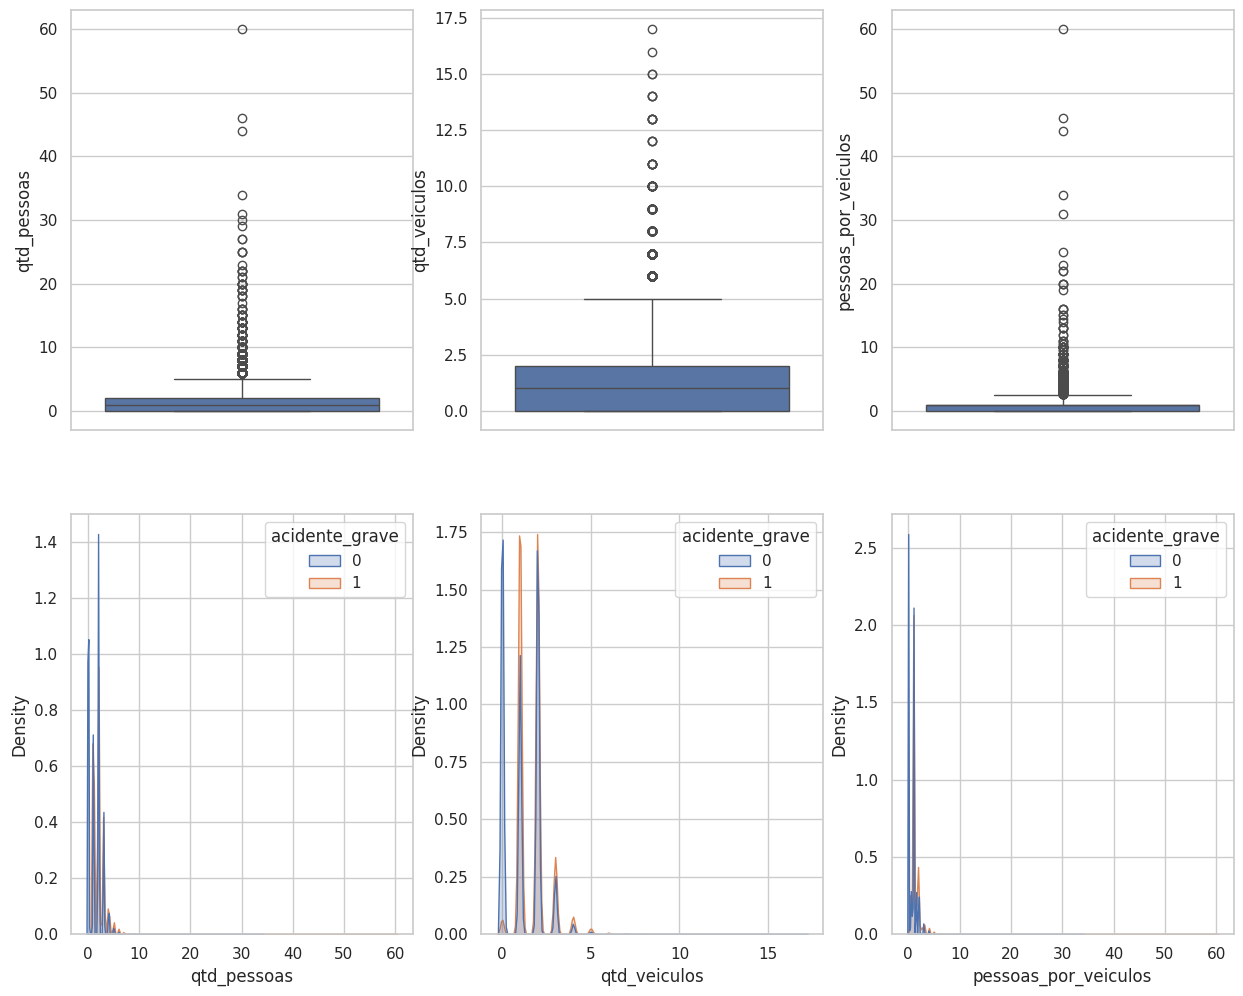

In [23]:
# Gráficos de features numéricas
## !! Acredito que Pode ser automatizado com .select_dtypes()!!
fig, ax = plt.subplots(2,3, figsize=(15,12))

sns.boxplot(ax = ax[0,0], data=X_train, y='qtd_pessoas')

sns.boxplot(ax = ax[0,1], data=X_train, y='qtd_veiculos')

sns.boxplot(ax = ax[0,2], data=X_train, y='pessoas_por_veiculos')

sns.kdeplot(ax = ax[1,0], data=X_train, x='qtd_pessoas', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[1,1], data=X_train, x='qtd_veiculos', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[1,2], data=X_train, x='pessoas_por_veiculos', hue=y_train, common_norm=False, fill=True)
plt.show()

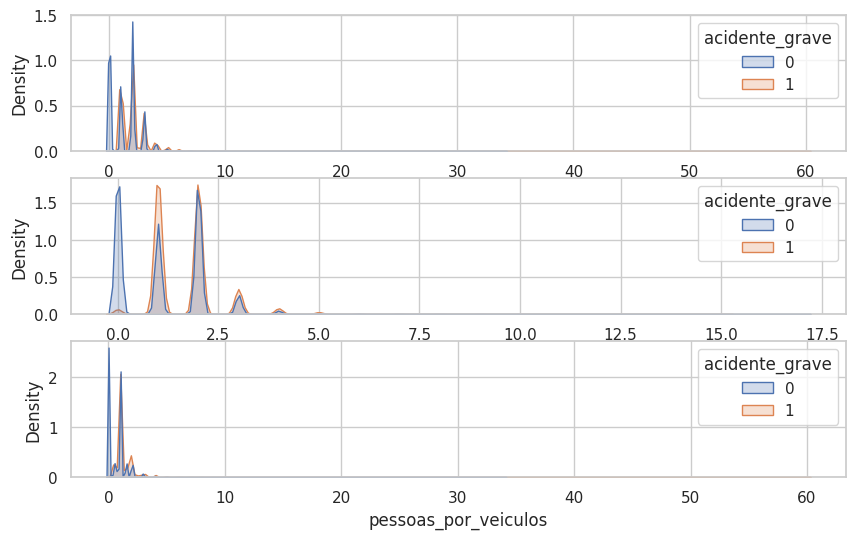

In [24]:
fig, ax = plt.subplots(3,1,figsize=(10,6))

sns.kdeplot(ax = ax[0], data=X_train, x='qtd_pessoas', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[1], data=X_train, x='qtd_veiculos', hue=y_train, common_norm=False, fill=True)

sns.kdeplot(ax = ax[2], data=X_train, x='pessoas_por_veiculos', hue=y_train, common_norm=False, fill=True)
plt.show()

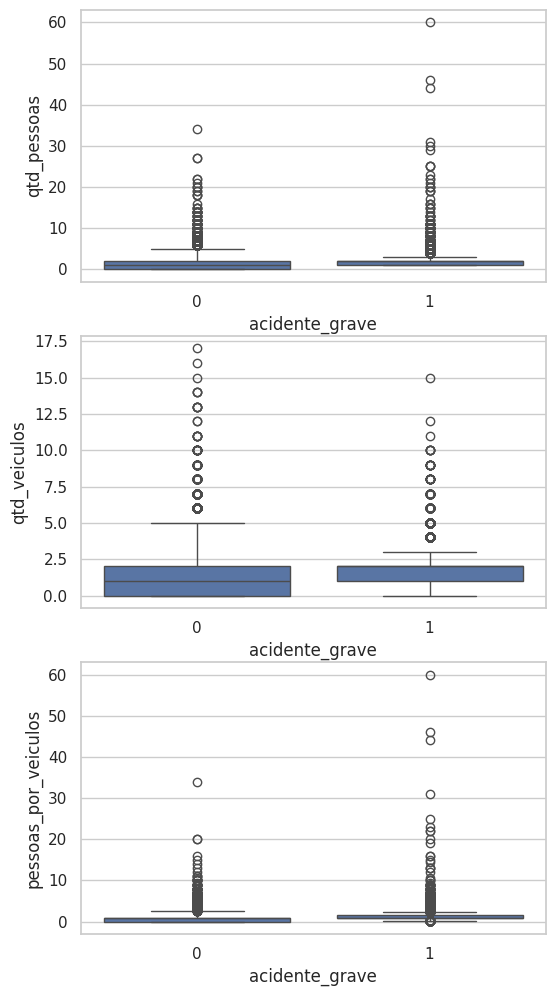

In [90]:
fig, ax = plt.subplots(3,1,figsize=(6,12))

sns.boxplot(ax=ax[0], x=y_train, y=X_train['qtd_pessoas'])

sns.boxplot(ax=ax[1], x=y_train, y=X_train['qtd_veiculos'], data=sinistro)

sns.boxplot(ax=ax[2], x=y_train, y=X_train['pessoas_por_veiculos'], data=sinistro)
plt.show()

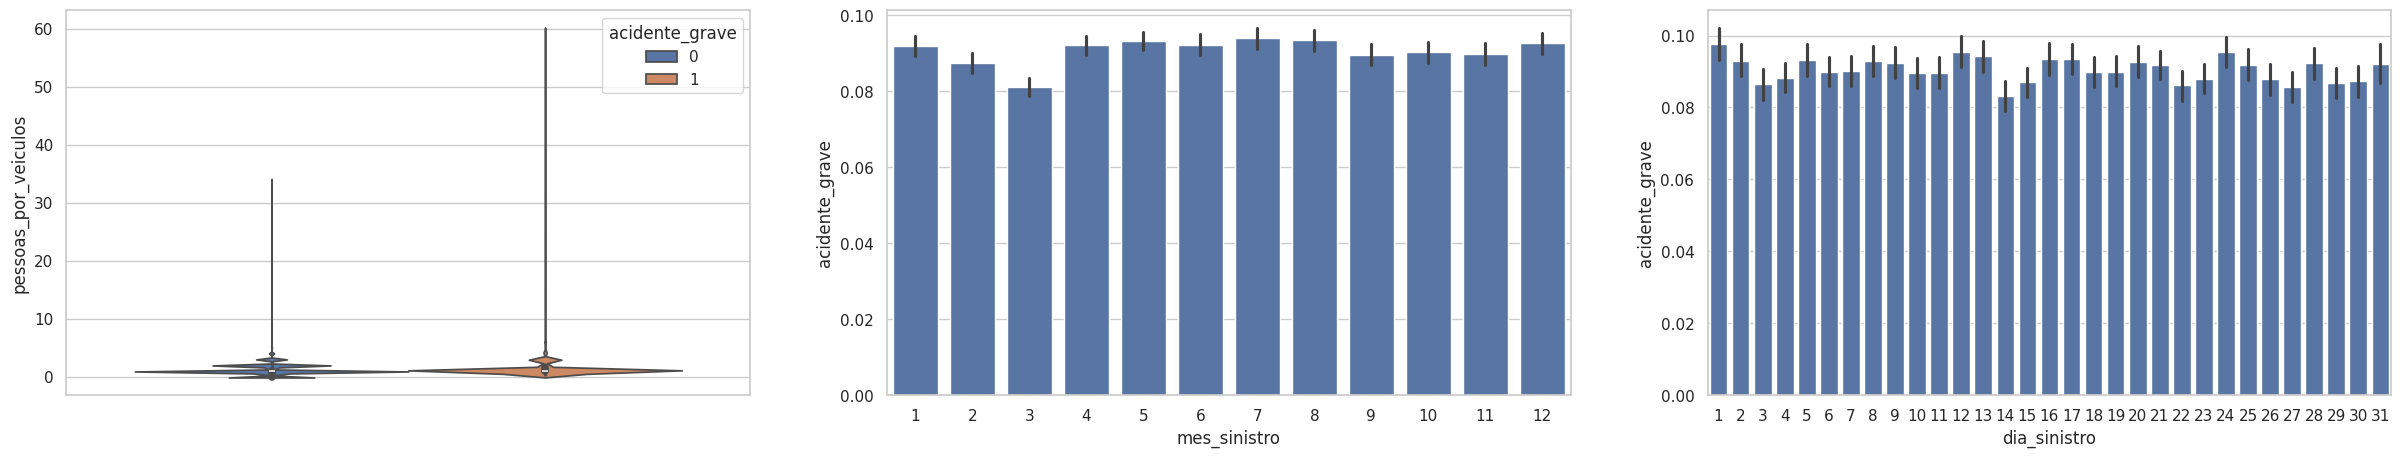

In [71]:
fig, ax = plt.subplots(1,3, figsize=(30,5))

sns.violinplot(ax = ax[0], y=X_train['pessoas_por_veiculos'], hue=y_train)

sns.barplot(ax = ax[1], x=X_train['mes_sinistro'], y=y_train)

sns.barplot(ax = ax[2], x=X_train['dia_sinistro'], y=y_train)
plt.show()

In [ ]:
## heatmap sem tipos de sinistro
mask = np.triu(np.ones_like(X_train.drop(columns=tipos).corr(numeric_only=True), dtype=bool))
fig, ax = plt.subplots(1,1, figsize=(19,19))
sns.heatmap(data=X_train.drop(columns=tipos).corr(numeric_only=True), 
            annot=True, 
            fmt='.2f', 
            mask=mask, 
            cmap='coolwarm')

sns.despine(fig=fig)
plt.tight_layout()
plt.show()

In [ ]:
## heatmap sem veiculos
mask = np.triu(np.ones_like(X_train.drop(columns=veiculos).corr(numeric_only=True), dtype=bool))
fig, ax = plt.subplots(1,1, figsize=(19,19))
sns.heatmap(data=X_train.drop(columns=veiculos).corr(numeric_only=True), 
            annot=True, 
            fmt='.2f', 
            mask=mask, 
            cmap='coolwarm')

sns.despine(fig=fig)
plt.tight_layout()
plt.show()

# Treinamento

In [17]:
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [ ]:
num_pipeline = pipeline.Pipeline([
    ('scaler', preprocessing.RobustScaler()),
])

cat_pipeline = pipeline.Pipeline([
    ('input_cat',impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = compose.ColumnTransformer(
    transformers=[
        ('num_transformer', num_pipeline, num_cols),
        ('cat_transformer', cat_pipeline, cat_cols),
    ]
)

model = ensemble.RandomForestClassifier(random_state=42,
                                        class_weight='balanced',)

pipe = pipeline.Pipeline([
    ('preprocessor',preprocessor),
    ('rnd_forest', model)
])


In [49]:
dummy_clf = pipeline.make_pipeline(
    preprocessor,
    dummy.DummyClassifier()
)
dummy_clf.fit(X_train, y_train)
most_frequent = any(dummy_clf.predict(X_train))
print(f'Most frequent class: {most_frequent}')
if most_frequent == False:
    most_frequent = 0
else:
    most_frequent = 1
print(f'Se o modelo chutar {most_frequent} para todas as predições, ele está certo em {(model_selection.cross_val_score(dummy_clf, X_train, y_train, cv=5, scoring='accuracy').mean())}% das vezes')
## 10% são 1
## se o modelo chutar 0 pra tudo ele estará certa em 90% das vezes

Most frequent class: False
Se o modelo chutar 0 para todas as predições, ele está certo em 0.9094147842520094% das vezes


In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Sinistro")

with mlflow.start_run(run_name=model.__str__()):
    
    pipe.fit(X_train, y_train)
    y_train_pred = model_selection.cross_val_predict(pipe, X_train, y_train, cv=5)
    y_train_proba = model_selection.cross_val_predict(pipe,X_train, y_train, cv=5, method='predict_proba')

    y_test_pred = pipe.predict(X_test)
    y_test_proba = pipe.predict_proba(X_test)
    
    accuracy = metrics.accuracy_score(y_train, y_train_pred)
    matrix = metrics.confusion_matrix(y_train, y_train_pred)
    precision = metrics.precision_score(y_train, y_train_pred)
    recall = metrics.recall_score(y_train, y_train_pred)
    f1_score = metrics.f1_score(y_train, y_train_pred)
    roc_auc = metrics.roc_auc_score(y_train, y_train_pred)
    auc_pr = metrics.average_precision_score(y_train, y_train_proba[:,1])

    recall_test = metrics.recall_score(y_test, y_test_pred)
    auc_pr_test = metrics.average_precision_score(y_test, y_test_proba[:,1])

    print('AUC-PR ', auc_pr)
    print('Accuracy ', accuracy)
    print(matrix)
    print('Precision ',precision)
    print('Recall ',recall)
    print('F1 ',f1_score)
    print('ROC AUC ',roc_auc)
    print(metrics.classification_report(y_test, y_test_pred))

    mlflow.log_metrics({
        'train_Accuracy':accuracy,
        'train_Precision':precision,
        'train_Recall':recall,
        'train_F1':f1_score,
        'train_roc_auc':roc_auc,
        'train_auc_pr':auc_pr,
        'test_recall':recall_test,
        'test_auc_pr':auc_pr_test
    })

In [53]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('rnd_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_transformer', ...), ('cat_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_train_pred = model_selection.cross_val_predict(pipe, X_train, y_train, cv=3)
y_train_proba = model_selection.cross_val_predict(pipe,X_train, y_train, cv=3, method='predict_proba')

y_test_pred = pipe.predict(X_test)
y_test_proba = pipe.predict_proba(X_test)

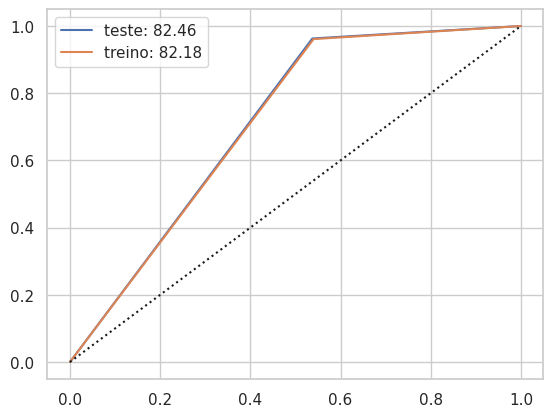

In [32]:
roc_test = metrics.roc_curve(y_test, y_test_pred)
roc_train = metrics.roc_curve(y_train, y_train_pred)

auc_train = metrics.roc_auc_score(y_train, y_train_proba[:,1])
auc_test = metrics.roc_auc_score(y_test, y_test_proba[:,1])

plt.plot(roc_test[0], roc_test[1])
plt.plot(roc_train[0], roc_train[1])
plt.plot([0, 1], [0, 1], 'k:')

plt.legend([
    f'teste: {100*auc_test:.2f}',
    f'treino: {100*auc_train:.2f}',
])
plt.show()

## Best features

In [ ]:
best_model = pipe.named_steps['rnd_forest']
features = pipe.named_steps['preprocessor'].get_feature_names_out()
importances = best_model.feature_importances_
features_importances = pd.DataFrame({'feature':features,
                                     'importance':importances}).sort_values(by='importance', 
                                                                            ascending=False)
best_features = features_importances['feature'].head(20).values

In [18]:
features_importances.head()

NameError: name 'features_importances' is not defined

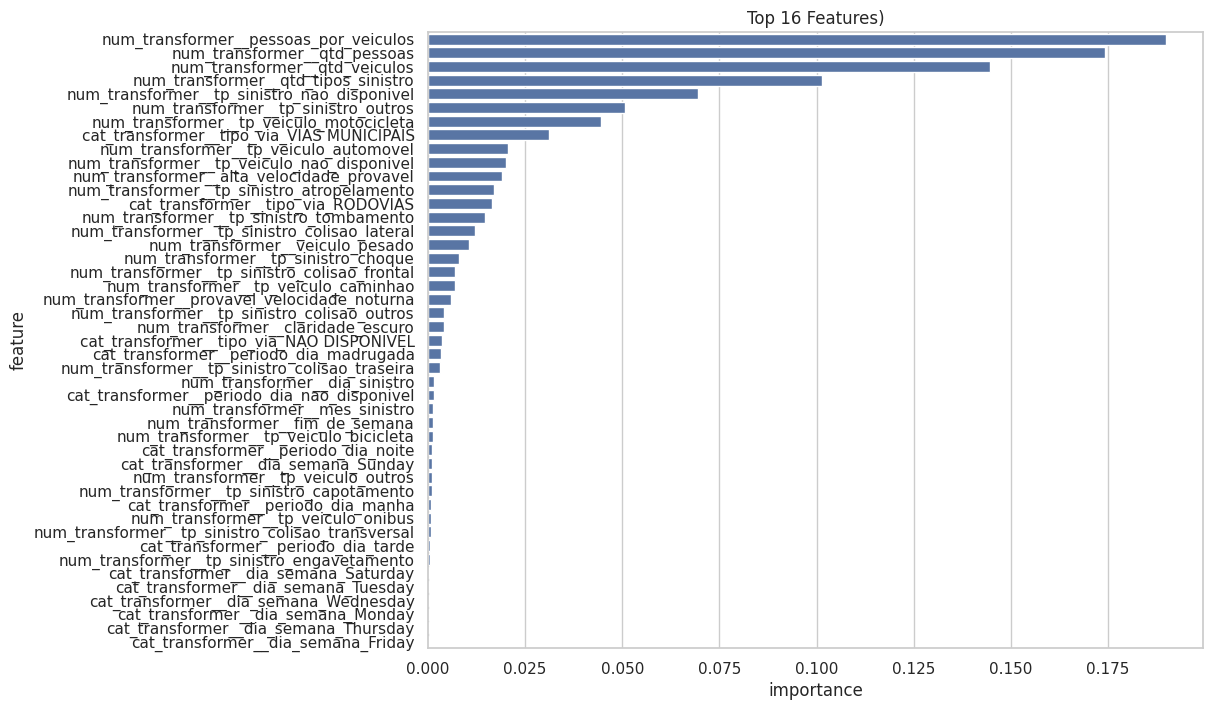

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=features_importances)
plt.title('Top 20 Features)')
plt.show()

In [56]:
best_features = [col.replace('num_transformer__','').replace('cat_transformer__','') for col in best_features]
best_features_names = [col for col in best_features if col in X_train.columns]

best_num_cols = X_train[best_features_names].select_dtypes(include=['int64','float64']).columns.tolist()
best_cat_cols = X_train[best_features_names].select_dtypes(include=['object']).columns.tolist()

In [ ]:
## Melhores Hyperparameters
from scipy.stats import randint

## para RandomizedSearchCV
param_distributions = {'rnd_forest__max_depth' : randint(low=1, high=50),
                      'rnd_forest__min_samples_leaf' : randint(low=1, high=4),
                 'rnd_forest__min_samples_split': randint(low=2,high=10),
                 'rnd_forest__n_estimators': randint(low=50,high=200)}
## remover hiperparâmetros no model
## mudar param_grid para param_distributions no grid_search
## adicionar n_iter=10

## para GridSearchCV
param_grid = {'rnd_forest__max_depth' : [10, 25, 50],
                 'rnd_forest__min_samples_split': [5, 10],
                 'rnd_forest__min_samples_leaf': [1, 2, 3],
                 'rnd_forest__n_estimators': [150, 300]}
## remover n_iter
## param_distributions para param_grid
## remover os hiperparâmetros no model

grid_search = model_selection.GridSearchCV(pipe,
                                                 param_grid=param_grid,
                                                 cv=3,
                                                 scoring='recall',)

grid_search.fit(X_train[best_features_names], y_train)

print('Best params: ',grid_search.best_params_)

Best params:  {'rnd_forest__max_depth': 10, 'rnd_forest__min_samples_leaf': 2, 'rnd_forest__min_samples_split': 10, 'rnd_forest__n_estimators': 300}


## Treino com best features

In [57]:
num_pipeline = pipeline.Pipeline([
    ('scaler', preprocessing.RobustScaler()),
])

cat_pipeline = pipeline.Pipeline([
    ('input_cat',impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = compose.ColumnTransformer(
    transformers=[
        ('num_transformer', num_pipeline, best_num_cols),
        ('cat_transformer', cat_pipeline, best_cat_cols),
    ]
)

model = ensemble.RandomForestClassifier(random_state=42,
                                        max_depth=10, 
                                        min_samples_leaf=2, 
                                        min_samples_split=10, 
                                        n_estimators=300,
                                        class_weight='balanced',)

pipe = pipeline.Pipeline([
    ('preprocessor',preprocessor),
    ('rnd_forest', model)
])

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Sinistro")

with mlflow.start_run(run_name=model.__str__()):
    
    pipe.fit(X_train[best_features_names], y_train)
    y_train_pred_best = model_selection.cross_val_predict(pipe, X_train[best_features_names], y_train, cv=3)
    y_train_proba_best = model_selection.cross_val_predict(pipe,X_train[best_features_names], y_train, cv=3, method='predict_proba')

    y_test_pred_best = pipe.predict(X_test[best_features_names])
    y_test_proba_best = pipe.predict_proba(X_test[best_features_names])

    matrix_best = metrics.confusion_matrix(y_train, y_train_pred_best)
    precision_best = metrics.precision_score(y_train, y_train_pred_best)
    recall_best = metrics.recall_score(y_train, y_train_pred_best)
    f1_score_best = metrics.f1_score(y_train, y_train_pred_best)
    auc_pr_best = metrics.average_precision_score(y_train, y_train_proba_best[:,1])

    test_precision_best = metrics.precision_score(y_test, y_test_pred_best)
    test_recall_best = metrics.recall_score(y_test, y_test_pred_best)
    test_auc_pr_best = metrics.average_precision_score(y_test, y_test_proba_best[:,1])


    print('Precision ',precision_best)
    print('Recall ',recall_best)
    print('F1 ',f1_score_best)
    print('AUC-PR ', auc_pr_best)
    print(matrix_best)

    mlflow.log_metrics({
        'train_Precision':precision_best,
        'train_Recall':recall_best,
        'train_F1':f1_score_best,
        'train_auc_pr':auc_pr_best,
        'test_auc_pr': test_auc_pr_best,
        'test_recall': test_recall_best,
        'test_precision': test_precision_best,
    })

In [97]:
pipe.fit(X_test[best_features_names], y_test)

y_pred_best = pipe.predict(X_test[best_features_names])
y_proba_best = pipe.predict_proba(X_test[best_features_names])

recall_test = metrics.recall_score(y_test, y_pred_best)
precision_test = metrics.precision_score(y_test, y_pred_best)
auc_pr_test = metrics.average_precision_score(y_test, y_proba_best[:,1])

print('recall ', recall_test)
print('precision ', precision_test)
print('auc_pr ', auc_pr_test)

recall  0.8347521281922884
precision  0.20929064657878219
auc_pr  0.5431803933545408


## Thresholds

In [96]:
y_proba_train_best = model_selection.cross_val_predict(pipe, X_train[best_features_names], y_train, cv=3, method='predict_proba')[:,1]

In [ ]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_proba_train_best)
## precision_recall_curve retorna n+1 valores no precision e recalls, e n thresholds
## [:-1] o último valor de precisions sempre é 1 e recalls sempre 0 para indicar o último valor do gráfico
min_recall = 0.9
mask = recalls[:-1] >= min_recall
# retorna index do True, do maior valor da lista
best_index = np.argmax(precisions[:-1][mask])
best_threshold = thresholds[mask][best_index]

y_pred_w_threshold = (y_proba_best >= best_threshold).astype(int)

print(best_threshold)
print(metrics.classification_report(y_test, y_pred_w_threshold))

              precision    recall  f1-score   support

           0       0.98      0.59      0.74    120294
           1       0.18      0.90      0.30     11982

    accuracy                           0.62    132276
   macro avg       0.58      0.75      0.52    132276
weighted avg       0.91      0.62      0.70    132276

0.4514454270423975


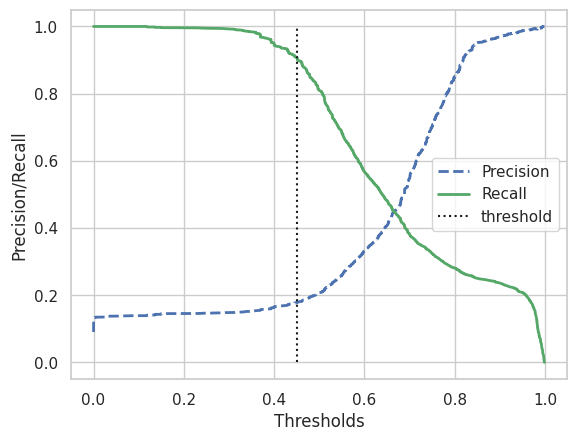

In [94]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(best_threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.xlabel('Thresholds')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()